# Определение перспективного тарифа для телеком-компании

**Описание проекта**

Анализируем данные компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: Смарт и Ультра. Чтобы запланировать бюджет на рекламу, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В н  ашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

**Тариф Смарт**</font></b>:

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей  

**Тариф Ультра**</font></b>:

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей  

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
calls=pd.read_csv('/datasets/calls.csv')
internet=pd.read_csv('/datasets/internet.csv')
messages=pd.read_csv('/datasets/messages.csv')
tariffs=pd.read_csv('/datasets/tariffs.csv')
users=pd.read_csv('/datasets/users.csv')

Таблица calls (информация о звонках):

id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок  

4 столбца и 202607 строк. Пропущенных значений нет.

In [3]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица internet (информация об интернет-сессиях):

id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  

4 столбца и 149396 строк. Пропущенных значений нет.  

In [4]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Таблица messages (информация о сообщениях):

id — уникальный номер сообщения  
message_date — дата сообщения   
user_id — идентификатор пользователя, отправившего сообщение  

3 столбца и 123036 строк. Пропущенных значений нет.  

In [5]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица tariffs (информация о тарифах):

tariff_name — название тарифа  
rub_monthly_fee — ежемесячная абонентская плата в рублях  
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
messages_included — количество сообщений в месяц, включённых в абонентскую плату  
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

 8 столбцов и 2 строк. Пропущенных значений нет.  

In [6]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица users (информация о пользователях):  

user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
city — город проживания пользователя  
tariff — название тарифного плана  

 8 столбцов и 500 строк. Пропущенные значения в столбце churn_date- 462 пропуска.Это столбец с датой прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).

In [7]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Общий вывод по данным:
Есть некоторые проблемы. Нужно кое-где поменять типы данных. Вещественный тип в звонках, потреблении интернета и кл-ве смс перевести в целочисленный. Присутствуют пропуски в churn_date. Есть смысл их просто поменять на 0(значит смены оператора не было). В соответствии требованиями оператора округлить длительность звонка и потребление интернета до целого большего.

# Предобработка данных

In [8]:
def fix_datetime(df, columns):
    for column in columns:
        df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
        
fix_datetime(calls, ['call_date'])
fix_datetime(users, ['reg_date', 'churn_date'])
fix_datetime(messages, ['message_date'])
fix_datetime(internet, ['session_date'])

Меняем значение столбцов на datetime

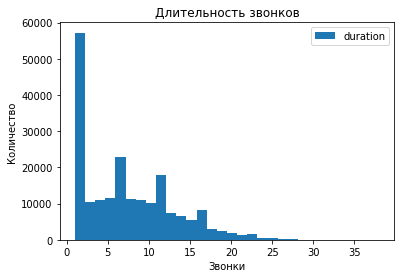

In [9]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int64')
calls['duration'].where(calls['duration'] > 0, 1, inplace=True)

calls['duration'].plot(x='duration', bins=30, style='o-',kind='hist')
plt.title('Длительность звонков')
plt.xlabel('Звонки')
plt.ylabel('Количество')
plt.legend()

plt.show()
# строю гистограмму всех звонков

Большe всего звонков в районе 2-х, а также 7 и 5 минут.

In [10]:
internet['mb_used'] = internet['mb_used'].astype('int64')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112,2018-11-25,1000
1,1,1000_1,1052,2018-09-07,1000
2,2,1000_2,1197,2018-06-25,1000
3,3,1000_3,550,2018-08-22,1000
4,4,1000_4,302,2018-09-24,1000


In [11]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

Создаём сводную таблицу для каждого абонента по месяцам

In [13]:
calls_by_month = calls.pivot_table(index=['month','user_id'],
                             values='duration',
                             aggfunc=['count', 'sum'])

Временная таблица для  представления массива записанных записей.

In [14]:
temp_df = pd.DataFrame(calls_by_month.to_records())

# Данные по месяцам.

In [15]:
monthly_revenue = pd.DataFrame()

In [16]:
monthly_revenue['user_id'] = temp_df['user_id']
monthly_revenue['month']   = temp_df['month']
monthly_revenue['calls']   = temp_df.iloc[:, 2]
monthly_revenue['minutes'] = temp_df.iloc[:, 3]

In [17]:
messages['month'] = messages['message_date'].dt.month
messages_by_month = messages.pivot_table(
    index=['month', 'user_id'],
    values='id',
    aggfunc='count')
temp_df = pd.DataFrame(messages_by_month.to_records()).rename(columns={'id': 'messages'})
monthly_revenue = monthly_revenue.merge(temp_df, on=['user_id', 'month'], how='outer')

In [18]:
internet['month'] = internet['session_date'].dt.month
internet_by_month = internet.pivot_table(index=['month', 'user_id'],
                                         values='mb_used',
                                         aggfunc='sum')
temp_df = pd.DataFrame(internet_by_month.to_records())
monthly_revenue = monthly_revenue.merge(temp_df, on=['user_id', 'month'], how='outer')
monthly_revenue
monthly_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3174 non-null float64
minutes     3174 non-null float64
messages    2717 non-null float64
mb_used     3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


Объединяем звонки и сообщения.

In [19]:
fix_columns = ['calls', 'minutes', 'messages']

for column in fix_columns:
    monthly_revenue[column] = monthly_revenue[column].fillna(0).astype('int64')
    
#Рассчитаем помесячную выручку с каждого абонента

monthly_revenue = monthly_revenue.merge(users, on='user_id', how='left').merge(tariffs, on='tariff', how='left')
monthly_revenue = monthly_revenue.drop(['first_name', 'last_name', 'age'], axis='columns')
monthly_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 17 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
calls                    3214 non-null int64
minutes                  3214 non-null int64
messages                 3214 non-null int64
mb_used                  3203 non-null float64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(12), object(2)
memory usage: 452.0+ KB


Объединяем таблицу звонки-сообщения-интернет и информация о пользователях.

In [20]:
monthly_revenue['minutes_extra']  = monthly_revenue['minutes'] - monthly_revenue['minutes_included']
monthly_revenue['messages_extra'] = monthly_revenue['messages'] - monthly_revenue['messages_included']
monthly_revenue['mb_used_extra']  = monthly_revenue['mb_used'] - monthly_revenue['mb_per_month_included']

In [21]:
#internet['gb_used'] = internet['gb_used'].apply(np.ceil)


def count_monthly_revenue(row):
    price_minutes= 0
    price_messages = 0
    price_mb = 0
    
    if row['minutes_extra'] > 0:
        minutes_price = row['minutes_extra'] * row['rub_per_minute']
        
    if row['messages_extra'] > 0:
        messages_price = row['messages_extra'] * row['rub_per_message']
        
    if row['mb_used_extra'] > 0:
        price_mb = np.ceil(row['mb_used_extra'] / 1024) * row['rub_per_gb']
        
    return price_minutes + price_messages + price_mb

In [22]:
monthly_revenue['rub_monthly_fee_extra'] = monthly_revenue.apply(count_monthly_revenue, axis=1)
monthly_revenue['rub_monthly_fee_total'] = monthly_revenue['rub_monthly_fee'] + monthly_revenue['rub_monthly_fee_extra']

Найдем количество минут, сообщений и интернет-трафика пользователей каждого тарифа в месяц

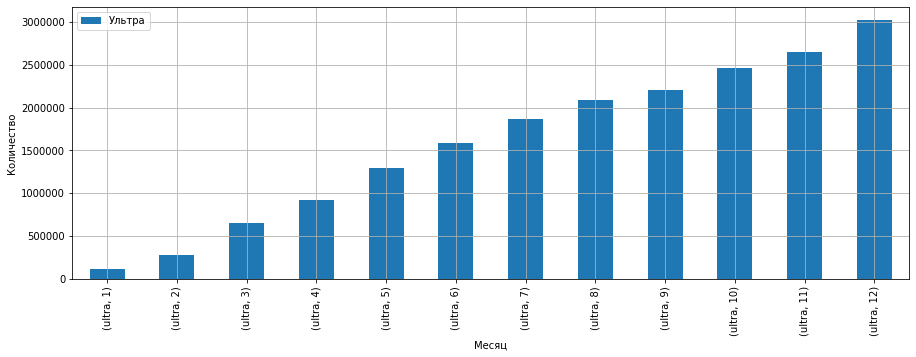

In [23]:
tariff_ultra=(monthly_revenue
     .query('tariff=="ultra"')
     .pivot_table(index=['tariff', 'month'],values=['minutes', 'messages', 'mb_used', 'rub_monthly_fee_extra', 'rub_monthly_fee_total'],aggfunc=('sum'))
     .plot(y='mb_used',grid=True,figsize=(15,5), style='o-',kind='bar',label='Ультра')
)

plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.legend()
tariff_ultra

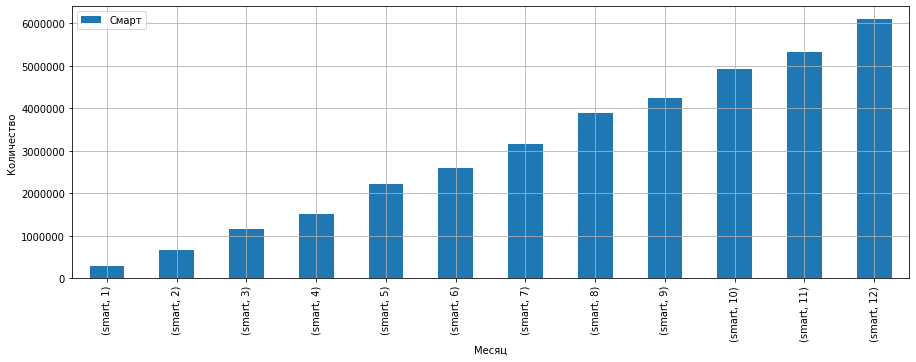

In [24]:
tariff_smart=(monthly_revenue
     .query('tariff=="smart"')
     .pivot_table(index=['tariff', 'month'],values=['minutes', 'messages', 'mb_used', 'rub_monthly_fee_extra', 'rub_monthly_fee_total'],aggfunc=('sum'))
     .plot(y='mb_used', grid=True,figsize=(15,5),style='o-',kind='bar',label='Смарт')
)

plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.legend()
tariff_smart

Предварительно абоненты с тарифом Смарт тратят больше на дополнительные минуты/сообщения/трафик. Посмотрим по каждом параметру сравнения более детально.

# Посчитаем среднее количество, дисперсию и стандартное отклонение

In [25]:
tariff_smart = monthly_revenue.query("tariff == 'smart'")
tariff_ultra = monthly_revenue.query("tariff == 'ultra'")

In [26]:
len(tariff_smart)

2229

In [27]:
len(tariff_ultra)

985

Выручка от пользователей с тарифом Смарт больше почти в два раза.

Посмотрим характеристики разброса методом describe()

In [28]:
tariff_smart['minutes'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: minutes, dtype: float64

In [29]:
tariff_ultra['minutes'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: minutes, dtype: float64

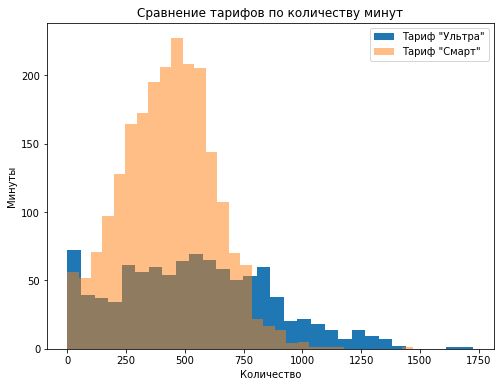

In [30]:
ax=tariff_ultra.plot(y='minutes', bins = 30,figsize=(8,6), kind='hist', label='Тариф "Ультра"')
tariff_smart.plot(y='minutes', bins = 30, figsize=(8,6), kind='hist', label='Тариф "Смарт"', alpha=0.5, ax=ax)
ax.set_title('Сравнение тарифов по количеству минут')
ax.set_xlabel('Количество') 
ax.set_ylabel('Минуты')
ax.legend()

График количества минут разговора по месяцам и обоим тарифам. Смарт также лидирует.

In [31]:
var_smart_minutes = np.var(tariff_smart['minutes'])
display(var_smart_minutes)

var_ultra_minutes = np.var(tariff_ultra['minutes'])
display(var_ultra_minutes)

37957.737941136875

105998.00527300368

In [32]:
tariff_smart['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [33]:
tariff_ultra['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

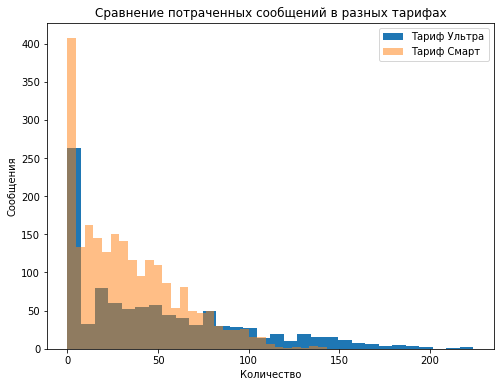

In [34]:
ax=tariff_ultra.plot(y='messages', bins = 30, figsize=(8,6), kind='hist', label='Тариф Ультра')
tariff_smart.plot(y='messages', bins = 30, figsize=(8,6), kind='hist', label='Тариф Смарт', alpha=0.5, ax=ax)
ax.set_title('Сравнение потраченных сообщений в разных тарифах')
ax.set_xlabel('Количество') 
ax.set_ylabel('Сообщения')
ax.legend()

График количества сообщений. В целом ситуация такая же, но тариф Ультра немного стабильнее по количеству сообщений, а абоненты Смарта явно их докупают.

In [35]:
var_smart_messages = np.var(tariff_smart['messages'])
display(var_smart_messages)

var_ultra_messages = np.var(tariff_ultra['messages'])
display(var_ultra_messages)

796.455482917076

2282.9460753948824

In [36]:
tariff_smart['mb_used'].describe()

count     2228.000000
mean     16194.844255
std       5854.702028
min          0.000000
25%      12630.250000
50%      16487.500000
75%      20017.250000
max      38510.000000
Name: mb_used, dtype: float64

In [37]:
tariff_ultra['mb_used'].describe()

count      975.000000
mean     19650.137436
std       9934.019669
min          0.000000
25%      11998.000000
50%      19377.000000
75%      26871.500000
max      49701.000000
Name: mb_used, dtype: float64

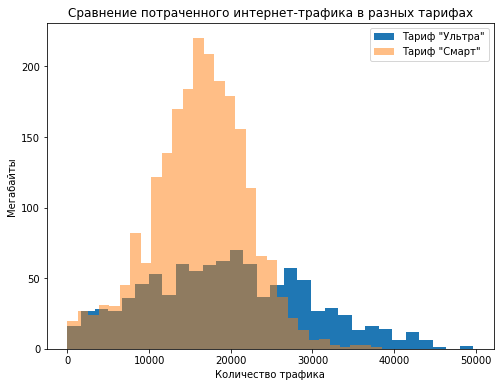

In [38]:
ax=tariff_ultra.plot(y='mb_used', bins = 30,figsize=(8,6), kind='hist', label='Тариф "Ультра"')
tariff_smart.plot(y='mb_used', bins = 30, figsize=(8,6), kind='hist', label='Тариф "Смарт"', alpha=0.5, ax=ax)
ax.set_title('Сравнение потраченного интернет-трафика в разных тарифах')
ax.set_xlabel('Количество трафика') 
ax.set_ylabel('Мегабайты')
ax.legend()

График количества потраченного интернета по месяцам и тарифам, Смарт впереди.

In [39]:
var_smart_mb_used = np.var(tariff_smart['mb_used'])
display(var_smart_mb_used)

var_ultra_mb_used = np.var(tariff_ultra['mb_used'])
display(var_ultra_mb_used)

34262150.942081

98583531.66316265

Абоненты тарифа Смарт выгоднее для компании, так как им не хватает входящего пакета услуг. Они чаще переплачивают за дополнительные минуты и интернет-трафик. Также абоненты тарифа Смарт мало пользуются сообщениями.
Абоненты тарифа Ультра, наоборот,не тратят до конца выделенные 3000 минут и 1000 сообщений.

## Проверим гипотезы

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Это утверждение возьмём за нулевую гипотезу.

In [40]:
tariff_smart['rub_monthly_fee_total'].mean()

1144.3472409152087

In [41]:
tariff_ultra['rub_monthly_fee_total'].mean()

2069.543147208122

Нулевая гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Альтернативная гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается

In [42]:
alpha = .01

results = st.ttest_ind(
    tariff_smart['rub_monthly_fee_total'], 
    tariff_ultra['rub_monthly_fee_total'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

p-значение: 7.951782431600798e-255
Не получилось отвергнуть нулевую гипотезу


p-значение: 1.725353702885943e-294

Результат говорит о том, что средняя выручка от тарифов различаются

# Средняя выручка пользователей из Москвы и других регионов

In [43]:
moscow_price = monthly_revenue['city'] == 'Москва'
monthly_revenue['city'].where(moscow_price, 'Другой регион', inplace=True)
city_monthly_price = monthly_revenue.pivot_table(
    index = ['city', 'month'],
    values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_extra', 'rub_monthly_fee_total'])
city_using = city_monthly_price.pivot_table(
    index = 'city', 
    values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_extra', 'rub_monthly_fee_total'])
city_using

,mb_used,messages,minutes,rub_monthly_fee_extra,rub_monthly_fee_total
city,,,,,
Другой регион,15715.795789,35.268458,424.594742,390.542318,1337.082365
Москва,17558.490200,33.944639,455.792652,352.508664,1447.473934


Вывод

В Москве абоненты потребляют больше интернет-трафика\ минут разговора, а вот сообщений у регионов побольше. Скорее всего это связано с большей плотностью населения, чем в регионах.
В других регионах тратят больше денег на дополнительные пакеты услуг.

In [44]:
display(monthly_revenue.query("city == 'Москва'")['rub_monthly_fee_total'].mean())

display(monthly_revenue.query("city == 'Другой регион'")['rub_monthly_fee_total'].mean())

1462.1931260229132

1419.842489435267

Нулевая гипотеза(утверждение по условию проекта): Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
Альтернативная гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [45]:
moscow_revenue = monthly_revenue.query("city == 'Москва'")['rub_monthly_fee_total']
other_cities_revenue = monthly_revenue.query("city == 'Другой регион'")['rub_monthly_fee_total']

alpha = .05

results = st.ttest_ind(moscow_revenue, other_cities_revenue)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22363257822604238
Не получилось отвергнуть нулевую гипотезу


p-значение: (0.186928363764759)0.22363257822604238
Не получилось отвергнуть нулевую гипотезу
Полученное p-значение говорит: если предположим, что выручки различаются, мы ошибемся в 22% случаев, довольно приличная цифра.

# Общий вывод

Абоненты с тарифом Смарт тратят больше на дополнительные минуты/сообщения/трафик, поэтому в итоге получается более прибыльным для Мегалайна.

Тариф Ультра больше гарантирует стабильную выручку телефоной компании, так как абоненты тратят больше денег по предоплате, но зато редко выходят за рамки количества приобретенных минут/сообщений/интернет-трафика.


В Москве абоненты потребляют больше интернет-трафика. Возможно связано с тем, что в городе больше точек с интернетом.
В других регионах тратят больше денег на дополнительные пакеты услуг.

Средняя выручка в Москве отличается от выручки пользователей из других регионов.